# Single-site

author: laquitainesteeve@gmail.com  

**purpose**: plot Horvath highpass filtered and referenced single site voltage trace; apply gain to uV.

execution time: 41 min

Special hardware: on CPU, does not require GPU.

storage: 5.72 GiB 

## Setup

Create and activate `demo` virtual environment kernel `demo` from (envs/demo.yml)

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from dandi.dandiapi import DandiAPIClient
import spikeinterface.extractors as se
import spikeinterface
from matplotlib import pyplot as plt;
import spikeinterface.preprocessing as spre
print("spikeinterface", spikeinterface.__version__)


# project path
proj_path = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(proj_path)

# import spikebias
from src.nodes.validation import noise

# setup dandi dataset parameters
dandiset_id = '001250'
filepath = 'sub-vivo-horvath-depth-2/sub-vivo-horvath-depth-2_ecephys.nwb'

# setup paths 
REC_PATH = "dataset/00_raw/recording_horvath_depth_2"

# setup recording parameters (as described in the paper)
GAIN_TO_UV = 0.195

# setup multi-processing parameters
job_params = {"verbose": True, "progress_bar": True, "overwrite": True, "n_jobs": 30, "chunk_size": 800000, "dtype": 'float32'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
spikeinterface 0.101.2


## Load horvath recording

In [50]:
%%time

# get the extractors from Dandi archive
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_path = asset.get_content_url(follow_redirects=1, strip_query=True)
Recording = se.NwbRecordingExtractor(file_path=s3_path, stream_mode="remfile")

# save
Recording.save(folder=REC_PATH, **job_params)

write_binary_recording 
n_jobs=30 - samples_per_chunk=800,000 - chunk_memory=195.31 MiB - total_memory=5.72 GiB - chunk_duration=40.00s


write_binary_recording: 100%|██████████| 93/93 [15:57<00:00, 10.29s/it]  


CPU times: user 80.3 ms, sys: 1.53 s, total: 1.61 s
Wall time: 16min 3s


BinaryFolderRecording: 128 channels - 20.0kHz - 1 segments - 73,773,360 samples 
                       3,688.67s (1.02 hours) - float32 dtype - 35.18 GiB

## Preprocess

In [ ]:
# get first 10 minutes
Recording = Recording.frame_slice(start_frame=0, end_frame=Recording.sampling_frequency*600)

# set gain to uV (0.195 described in https://doi.org/10.1038/s41597-021-00970-3)
Recording.set_channel_gains(GAIN_TO_UV)

# preprocess
Recording = spre.highpass_filter(Recording, freq_min=300)
Recording = spre.common_reference(Recording, reference="global", operator="median")

# load voltage traces 
traces = Recording.get_traces()
traces_in_uV = Recording.get_traces(return_scaled=True)

# report metadata
print("s3_path:", s3_path)
print('\n Recording extractor:', Recording)
print("trace data shape:", traces.shape)
print("gain_to_uV:", Recording.get_property('gain_to_uV'))
print("offset_to_uV: ", Recording.get_property('offset_to_uV'))

s3_path: https://dandiarchive.s3.amazonaws.com/blobs/4d2/875/4d2875ba-d83b-44d5-9036-74f42e19e8a0

 Recording extractor: CommonReferenceRecording: 128 channels - 20.0kHz - 1 segments - 12,000,000 samples 
                          600.00s (10.00 minutes) - int16 dtype - 2.86 GiB
trace data shape: (12000000, 128)
gain_to_uV: [0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195 0.195
 0.195 0.195 0.19

## Plot single-trace and calculate noise (MAD)

nb of 1-sec windows: 600
Background noise level in uV (min MAD over windows): 62.742863
nb of 1-sec windows: 600
Background noise level in uV (min MAD over windows): 12.234857
CPU times: user 24.7 ms, sys: 20 μs, total: 24.7 ms
Wall time: 24.1 ms


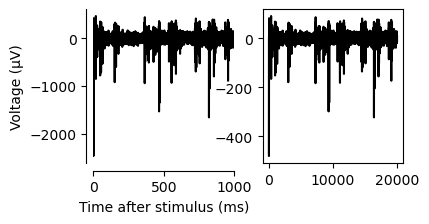

In [48]:
%%time 

# parameters
LAYER = 'L5'
STIM_START = 0 #15868410
SITE_IX = 79
SFREQ = int(Recording.get_sampling_frequency())

# get one second trace to plot
onesecond = np.arange(STIM_START, STIM_START + SFREQ, 1).astype(int)
layers = Recording.get_property("layers")
L5_site = np.where(layers == LAYER)[0][SITE_IX]
fig_data = traces[onesecond, L5_site]

# plot
YMAX = 60
fig, ax = plt.subplots(1, 2, figsize=(4,2))

# raw ---------------------------------
ax[0].plot(fig_data, color="k")

# legend
ax[0].spines[["right", "top"]].set_visible(False)
ax[0].set_ylabel("Voltage (\u03bcV)")
ax[0].set_xlabel("Time after stimulus (ms)")
#ax[0].set_yticks([-120, 0, YMAX], [-120, 0, YMAX])
#ax[0].set_ylim([-120, YMAX])
ax[0].set_xticks([0, SFREQ / 2, SFREQ], [0, 500, 1000])
ax[0].set_xlim([0, SFREQ])

# disconnected
ax[0].spines["bottom"].set_position(("axes", -0.05))
ax[0].yaxis.set_ticks_position("left")
ax[0].spines["left"].set_position(("axes", -0.05))

# report noise (min(MAD) over segments of 1 sec) here
wind_end = int(np.floor(len(traces)/SFREQ))
bkg_noise = noise.measure_trace_noise(traces[onesecond, L5_site], SFREQ, wind_end)
print("nb of 1-sec windows:", len(bkg_noise))
print("Background noise level in uV (min MAD over windows):", min(bkg_noise))



# scaled to uV ---------------------------------
fig_data = traces_in_uV[onesecond, L5_site]

# plot figure
ax[1].plot(fig_data, color="k")

# report noise (min(MAD) over segments of 1 sec) here
wind_end = int(np.floor(len(traces_in_uV)/SFREQ))
bkg_noise = noise.measure_trace_noise(traces_in_uV[onesecond, L5_site], SFREQ, wind_end)
print("nb of 1-sec windows:", len(bkg_noise))
print("Background noise level in uV (min MAD over windows):", min(bkg_noise))

### References

https://spikeinterface.readthedocs.io/en/stable/tutorials/extractors/plot_2_working_with_unscaled_traces.html#working-with-unscaled-traces